In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import LMCE.cfusdlog as cfusdlog
from LMCE.error_estimation import error_calculator

plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times']

In [2]:
# TABLE_DESCRIPTION = "Comparison of average deviation from desired flight path (meters) of the quadrotor carrying a payload."
TABLE_DESCRIPTION = "Comparison of average deviation from desired flight path (meters) of the quadrotor with no payload."
LABEL = "results_nopayload"

NN_KEY = "nn_output.f_x"
INDI_KEY = "ctrlLee.tau_rpm_fx"

In [3]:
tests = {
    "Circle": {
        "folder": "circle_test",
    },
    "Figure8": {
        "folder": "figure_8_tests",
    },
    "Helix": {
        "folder": "helix_fast",
        "nolee": True,
    },
    # "Helix Slow": {
    #     "folder": "helix_tests",
    # },
}

for k, v in tests.items():
    errors = [[] for _ in range(4)]
    total_flights = [0 for _ in range(4)]

    for filename in os.listdir(v["folder"]):
        file_path = os.path.join(v["folder"], filename)

        i = int(filename[-2:])
        if i % 4 == 3 and "nolee" in v:
            continue

        data = cfusdlog.decode(file_path)['fixedFrequency']

        using_nn = NN_KEY in data.keys() and bool(sum(data[NN_KEY]))
        using_indi = INDI_KEY in data.keys() and bool(sum(data[INDI_KEY]))

        if i % 4 == 0:
            using_nn = True
            using_indi = False
        if i % 4 == 1:
            using_nn = False
            using_indi = True
        if i % 4 == 2:
            using_nn = True
            using_indi = True
        if i % 4 == 3:
            using_nn = False
            using_indi = False

        real_pos = [data["stateEstimate.x"], data["stateEstimate.y"], data["stateEstimate.z"]]
        target_pos = np.array([data["ctrltargetZ.x"], data["ctrltargetZ.y"], data["ctrltargetZ.z"]])/1000
        target_pos = target_pos.tolist()
    
        start_time = data['timestamp'][0]
        start_cutoff = int(((data['timestamp'] - start_time) / 1e3)[0])
        error = error_calculator(real_pos, target_pos, cutoff_start=start_cutoff, vis=False)
        print(f"{filename}: NN: {using_nn}, INDI: {using_indi}, error: {error}")

        if using_nn and using_indi:
            errors[3].append(error)
            total_flights[3] += 1
        elif using_nn:
            errors[2].append(error)
            total_flights[2] += 1
        elif using_indi:
            errors[1].append(error)
            total_flights[1] += 1
        else:
            errors[0].append(error)
            total_flights[0] += 1

    errors_mean = [np.mean(e) for e in errors]
    errors_std = [np.std(e) for e in errors]

    print("Total flights ---------------")
    print("Lee+NN+INDI: ", total_flights[3])
    print("Lee+NN: ", total_flights[2])
    print("Lee+INDI: ", total_flights[1])
    print("Lee: ", total_flights[0])

    tests[k]["mean_error"] = errors_mean
    tests[k]["std_error"] = errors_std
    tests[k]["all_error"] = errors

li04: NN: True, INDI: False, error: 0.05230487754112469
li03: NN: False, INDI: False, error: 0.07268352979275641
li35: NN: False, INDI: False, error: 0.06863671936710844
li32: NN: True, INDI: False, error: 0.04972361384166022
li33: NN: False, INDI: True, error: 0.04262138609233252
li34: NN: True, INDI: True, error: 0.04317074541556273
li02: NN: True, INDI: True, error: 0.04335746666194499
li05: NN: False, INDI: True, error: 0.046292475175261916
li18: NN: True, INDI: True, error: 0.04528090988771999
li27: NN: False, INDI: False, error: 0.06603210213311726
li20: NN: True, INDI: False, error: 0.05071246021790074
li29: NN: False, INDI: True, error: 0.045831412713595546
li16: NN: True, INDI: False, error: 0.0444339148151226
li11: NN: False, INDI: False, error: 0.06813657460507327
li10: NN: True, INDI: True, error: 0.04436224606341916
li28: NN: True, INDI: False, error: 0.04418145149414626
li17: NN: False, INDI: True, error: 0.04990900039712965
li21: NN: False, INDI: True, error: 0.047380355

/Users/tupryk/opt/miniconda3/envs/robocup/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/tupryk/opt/miniconda3/envs/robocup/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/tupryk/opt/miniconda3/envs/robocup/lib/python3.10/site-packages/numpy/_core/_methods.py:227: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/tupryk/opt/miniconda3/envs/robocup/lib/python3.10/site-packages/numpy/_core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/tupryk/opt/miniconda3/envs/robocup/lib/python3.10/site-packages/numpy/_core/_methods.py:219: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [16]:
min_error = min(errors_mean)
min_std = min(errors_std)

error_strs = [f"$\mathbf{{{e:.4f}}}$" if e == min_error else f"{e:.4f}" for e in errors_mean]
error_strds = [f"$\mathbf{{{std:.4f}}}$" if std == min_std else f"{std:.4f}" for std in errors_std]

title = ""
for i, k in enumerate(tests.keys()):
    title += k
    if i != len(tests.keys())-1:
      title += " & "

errors = []
for i in range(4):
  errors_lee = ""
  for j, k in enumerate(tests.keys()):
      min_error = min([e for e in tests[k]["mean_error"] if str(e) != "nan"])
      error = tests[k]["mean_error"][i]
      std = tests[k]["std_error"][i]
      # if "nolee" in tests[k] and i == 3:
      #    errors_lee += f"--"
      # else:
      if str(error) == "nan":
        errors_lee += "--"
      else:
        errors_lee += f"${error:.4f}" if error != min_error else f"$\mathbf{{{error:.4f}}}"
        errors_lee += f" \pm {std:.4f}$"

      if j != len(tests.keys())-1:
        errors_lee += " & "
  errors.append(errors_lee)

latex_text = f"""\\begin{{table}}[htbp]
  \centering
  \caption{{{TABLE_DESCRIPTION}}}
  \\begin{{tabular}}{{{"|c"*(len(tests.keys())+1) + "|"}}}
    \hline
    & {title} \\\\
    \hline
    Lee & {errors[0]} \\\\
    \hline
    INDI & {errors[1]} \\\\
    \hline
    IL-NDI & {errors[2]} \\\\
    \hline
    NA-INDI & {errors[3]} \\\\
    \hline
  \end{{tabular}}
  \label{{tab:{LABEL}}}
\end{{table}}"""

In [17]:
print(latex_text)

\begin{table}[htbp]
  \centering
  \caption{Comparison of average deviation from desired flight path (meters) of the quadrotor with no payload.}
  \begin{tabular}{|c|c|c|c|}
    \hline
    & Circle & Figure8 & Helix \\
    \hline
    Lee & $0.0752 \pm 0.0122$ & $0.0729 \pm 0.0031$ & -- \\
    \hline
    INDI & $0.0455 \pm 0.0024$ & $0.0453 \pm 0.0031$ & $0.0316 \pm 0.0019$ \\
    \hline
    IL-NDI & $0.0482 \pm 0.0024$ & $0.0432 \pm 0.0024$ & $0.0290 \pm 0.0015$ \\
    \hline
    LA-INDI & $\mathbf{0.0450} \pm 0.0028$ & $\mathbf{0.0413} \pm 0.0013$ & $\mathbf{0.0286} \pm 0.0011$ \\
    \hline
  \end{tabular}
  \label{tab:results_nopayload}
\end{table}


Circle


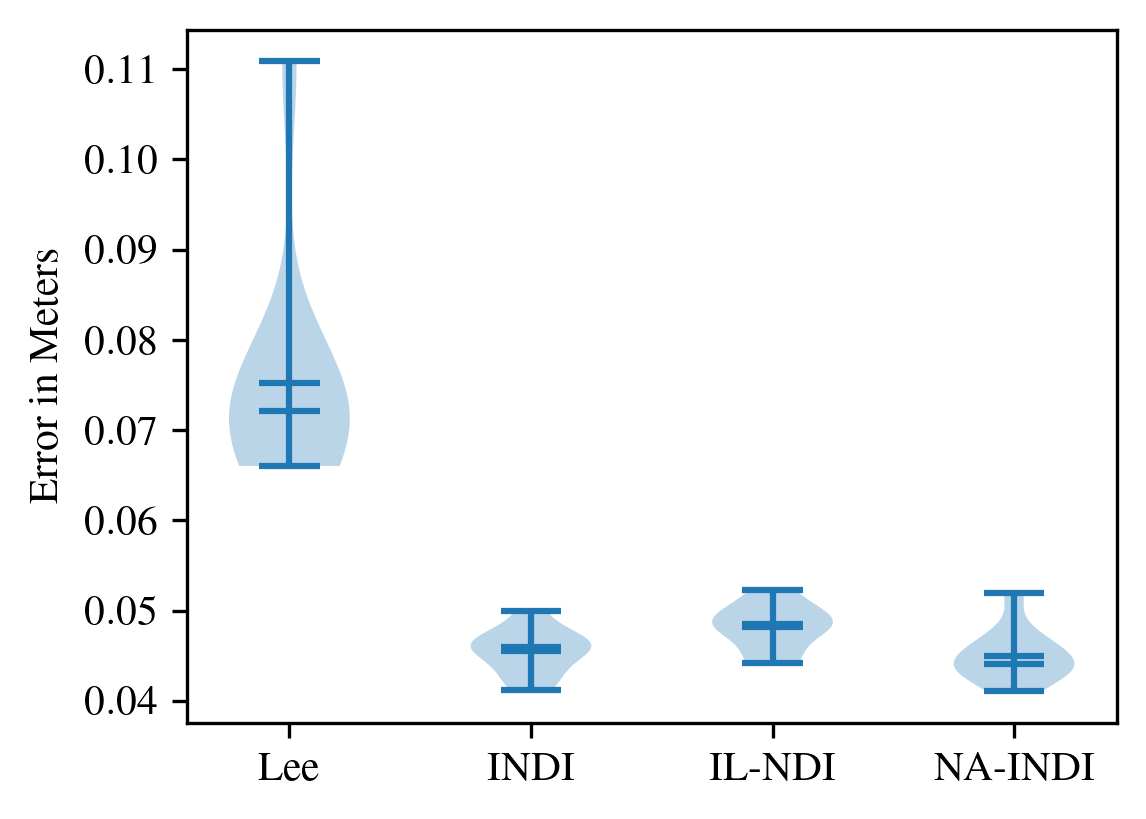

Figure8


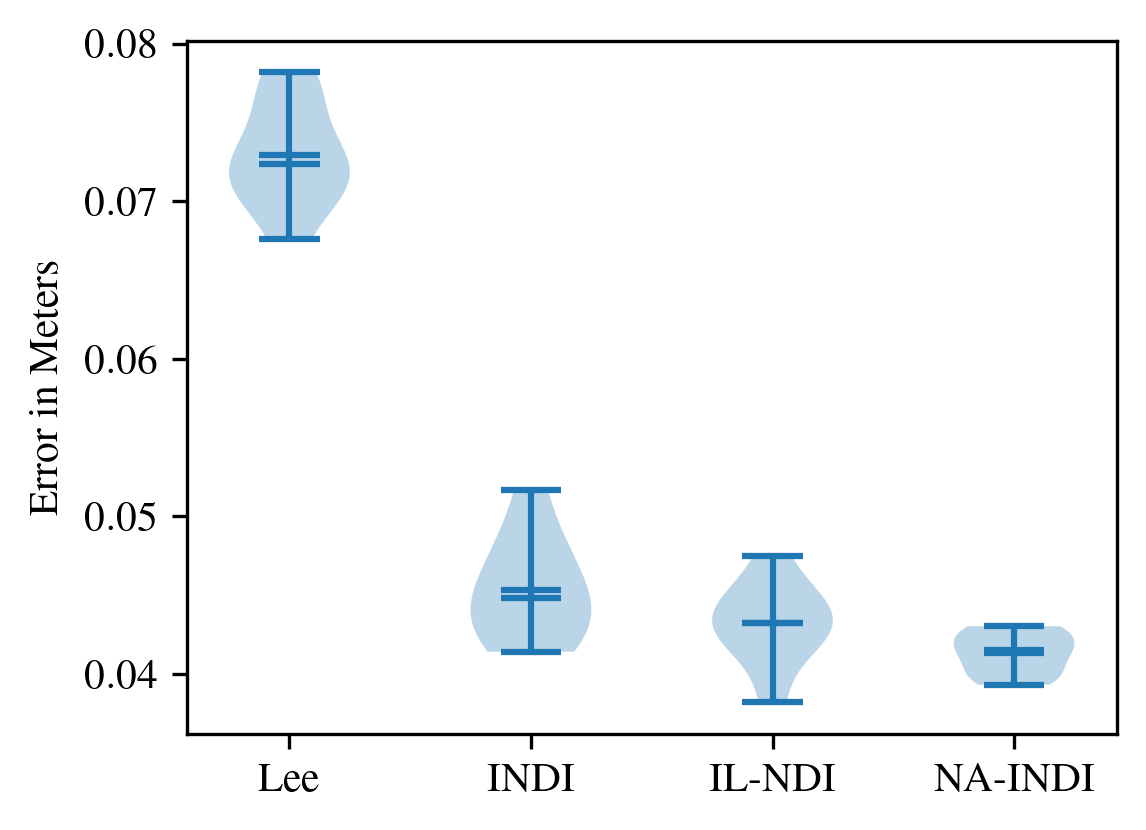

Helix


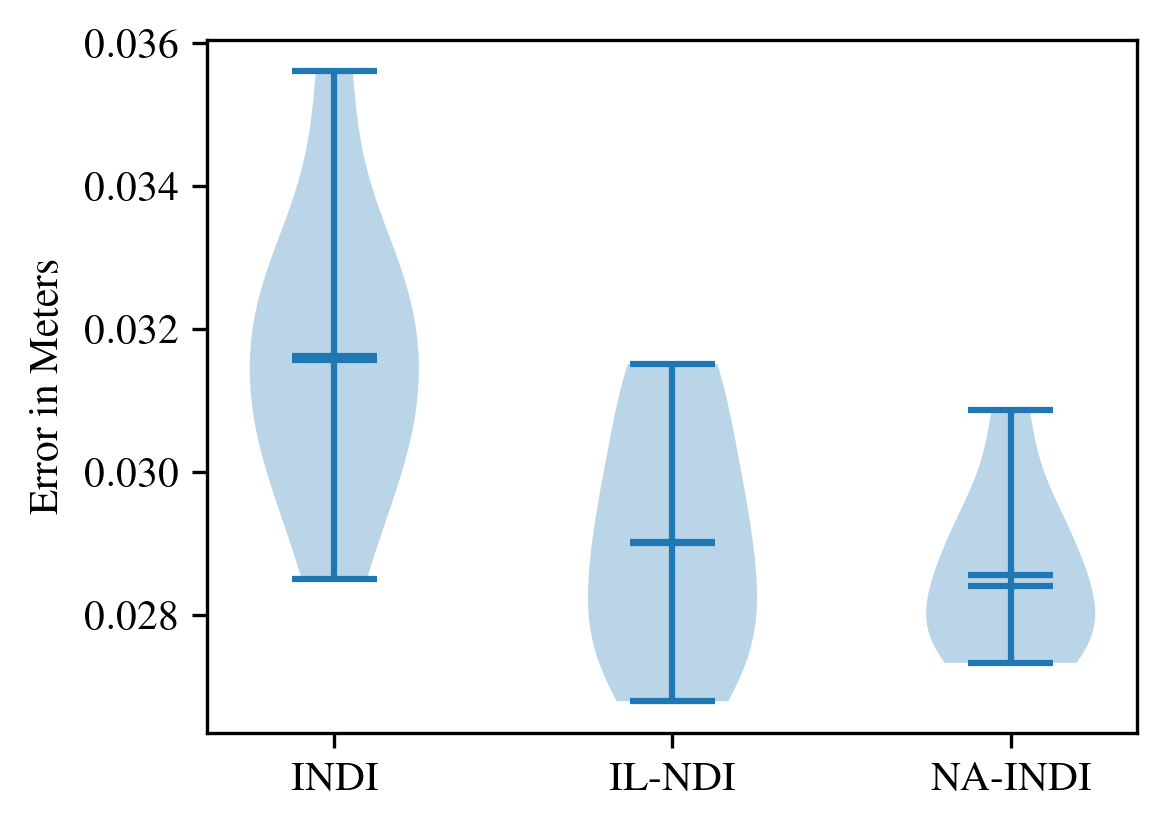

In [18]:
for k in tests.keys():
    data = [es for es in tests[k]["all_error"] if len(es) != 0]
    if len(data) == 4:
        labels = ["Lee", "INDI", "IL-NDI", "NA-INDI"]
        locations = [1, 2, 3, 4]
    else:
        labels = ["INDI", "IL-NDI", "NA-INDI"]
        locations = [1, 2, 3]

    plt.figure(figsize=(4, 3), dpi=300)
    plt.violinplot(data, showmeans=True, showmedians=True)

    plt.xticks(ticks=locations, labels=labels)
    plt.ylabel("Error in Meters")
    print(k)

    plt.show()

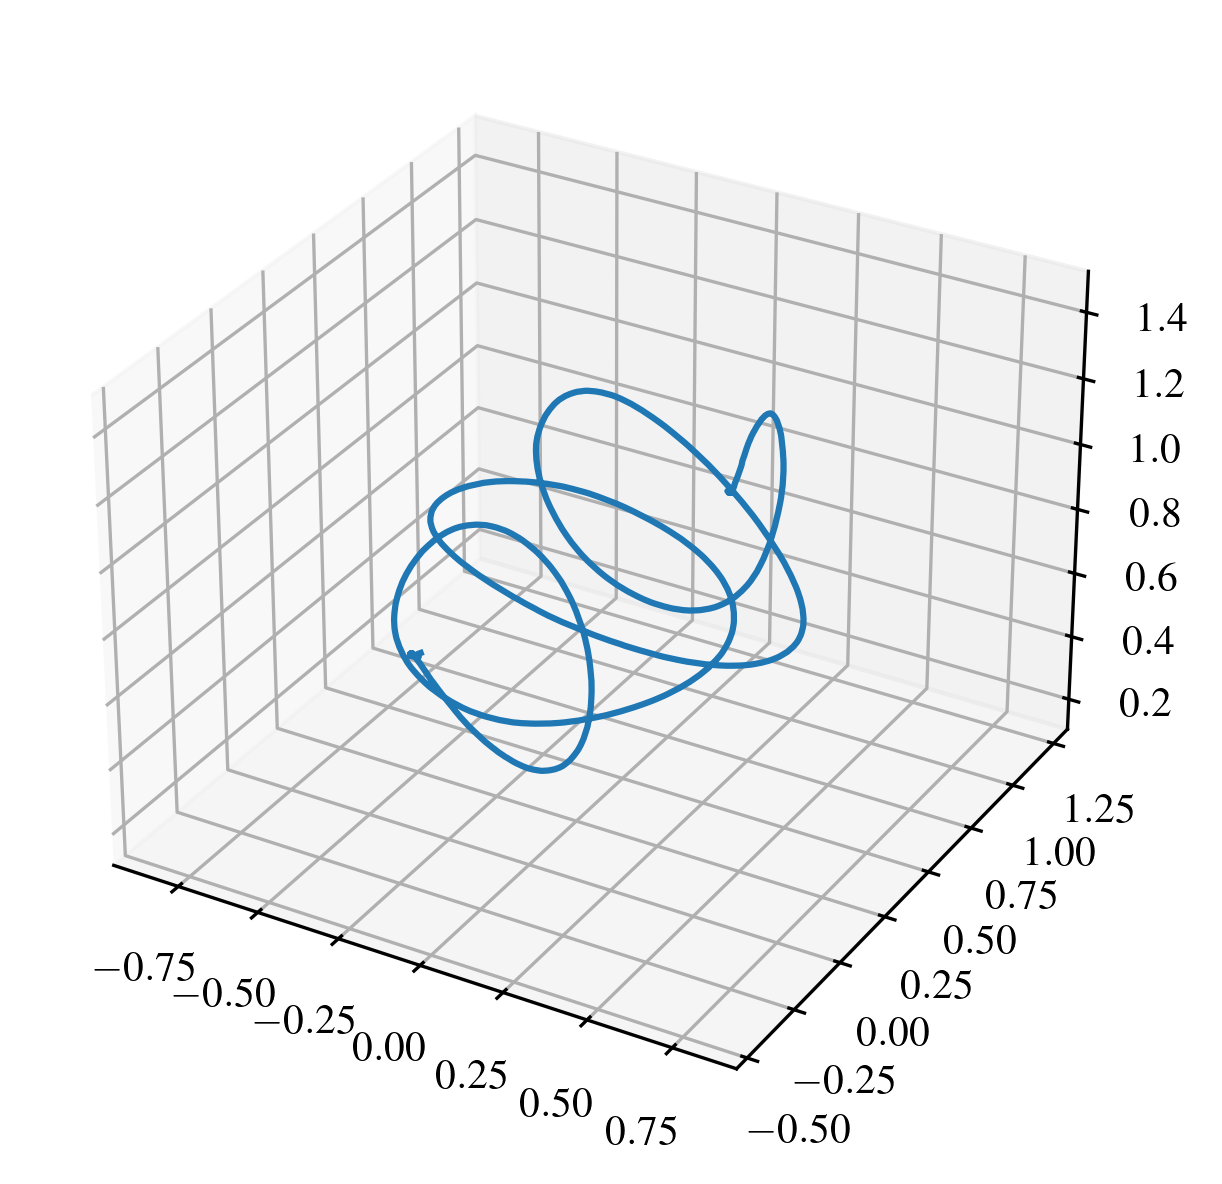

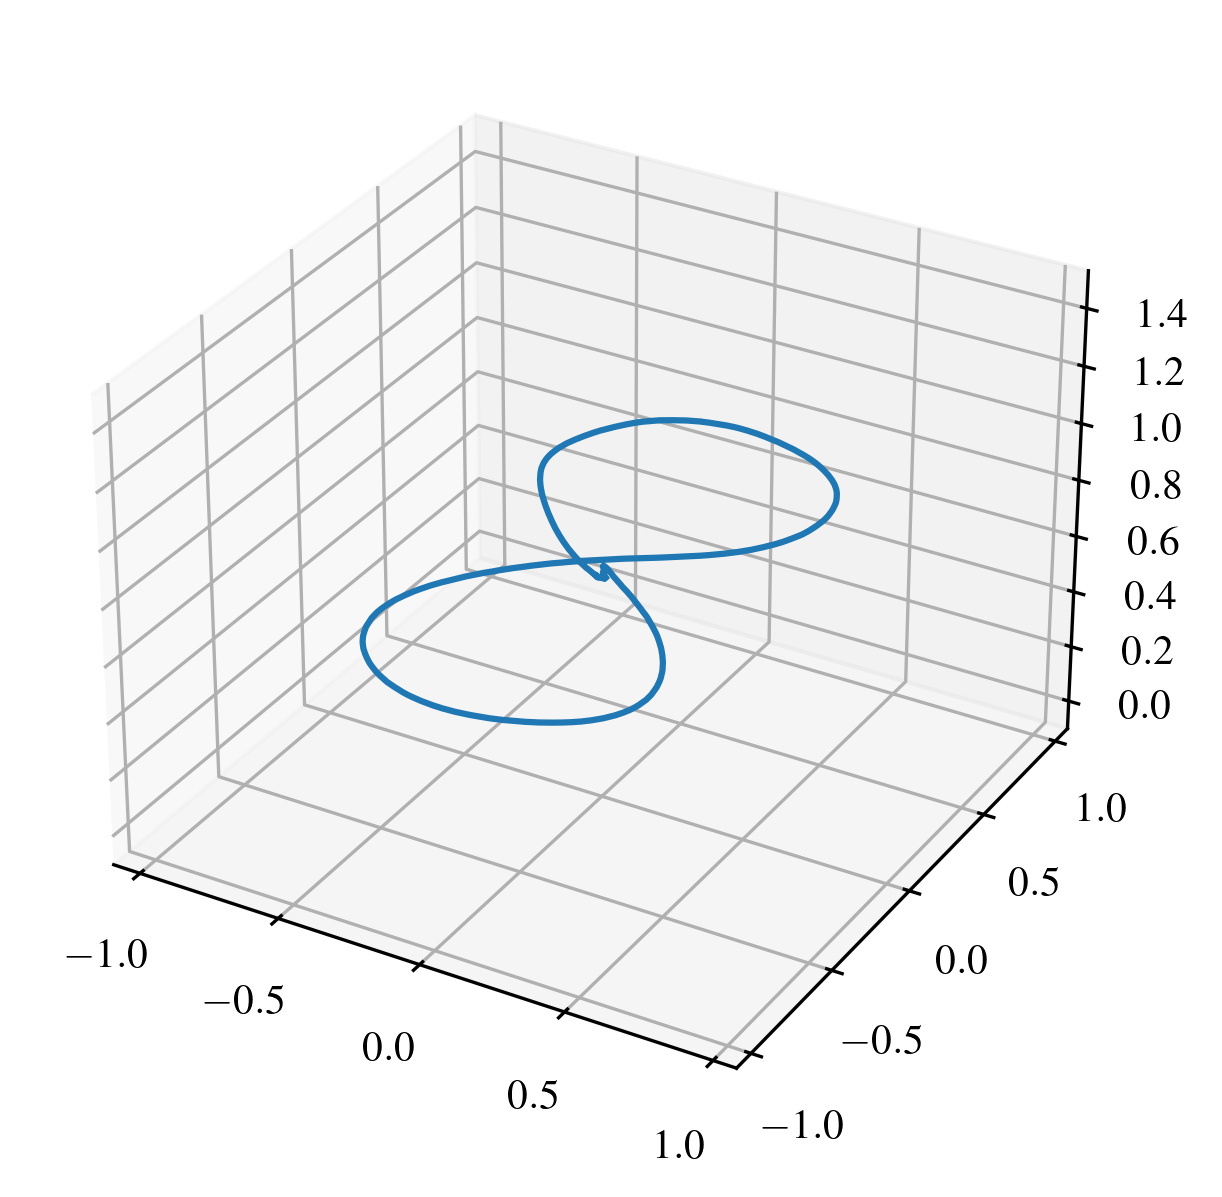

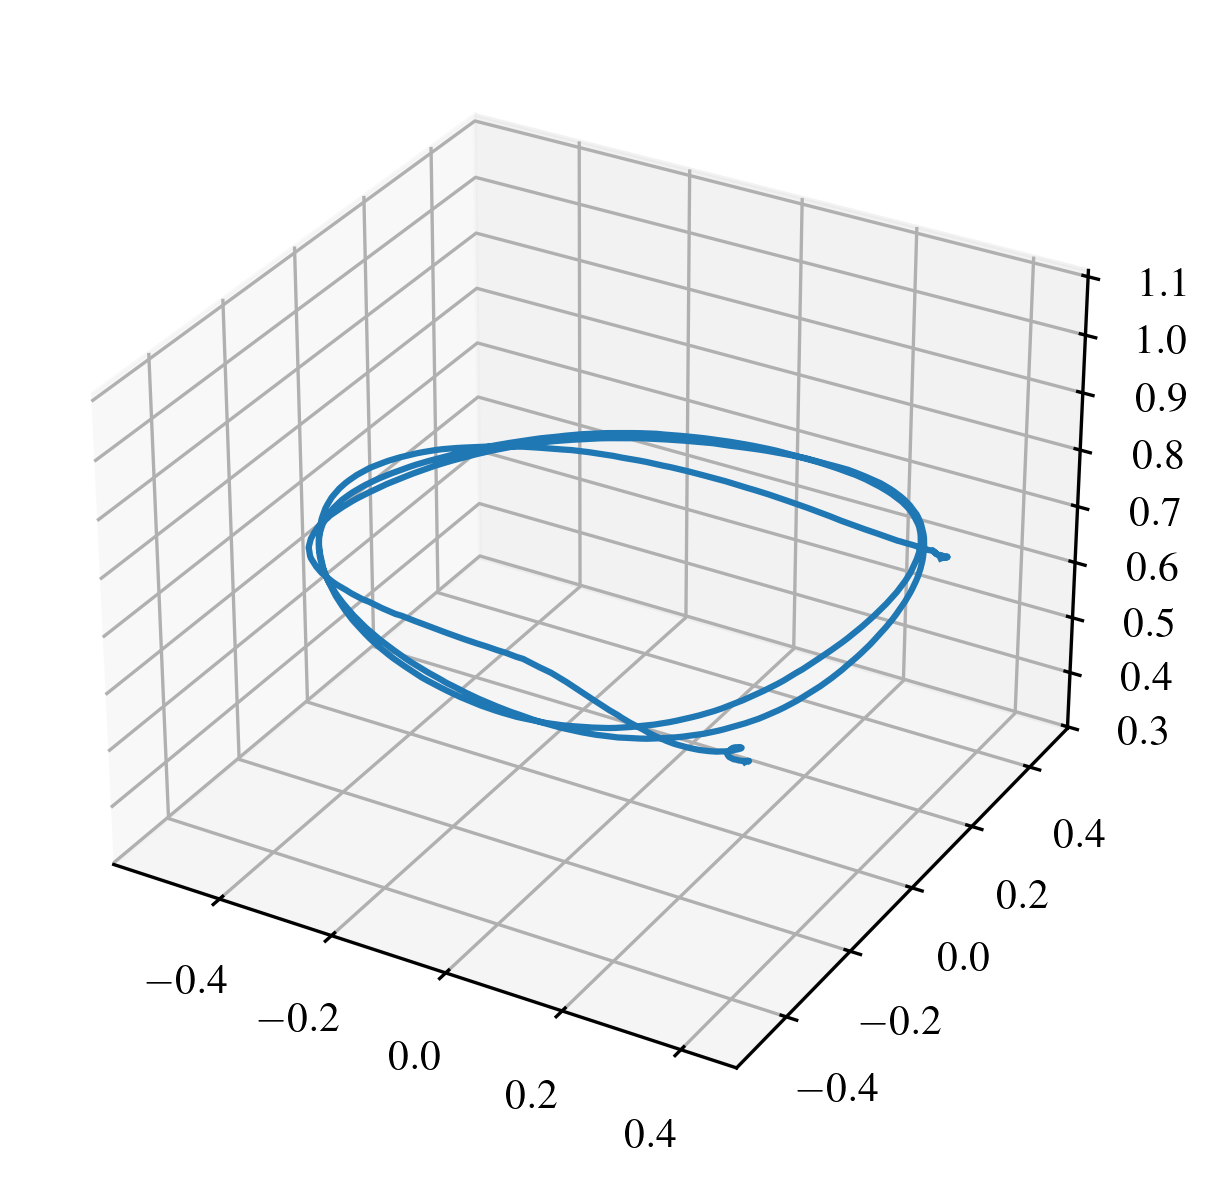

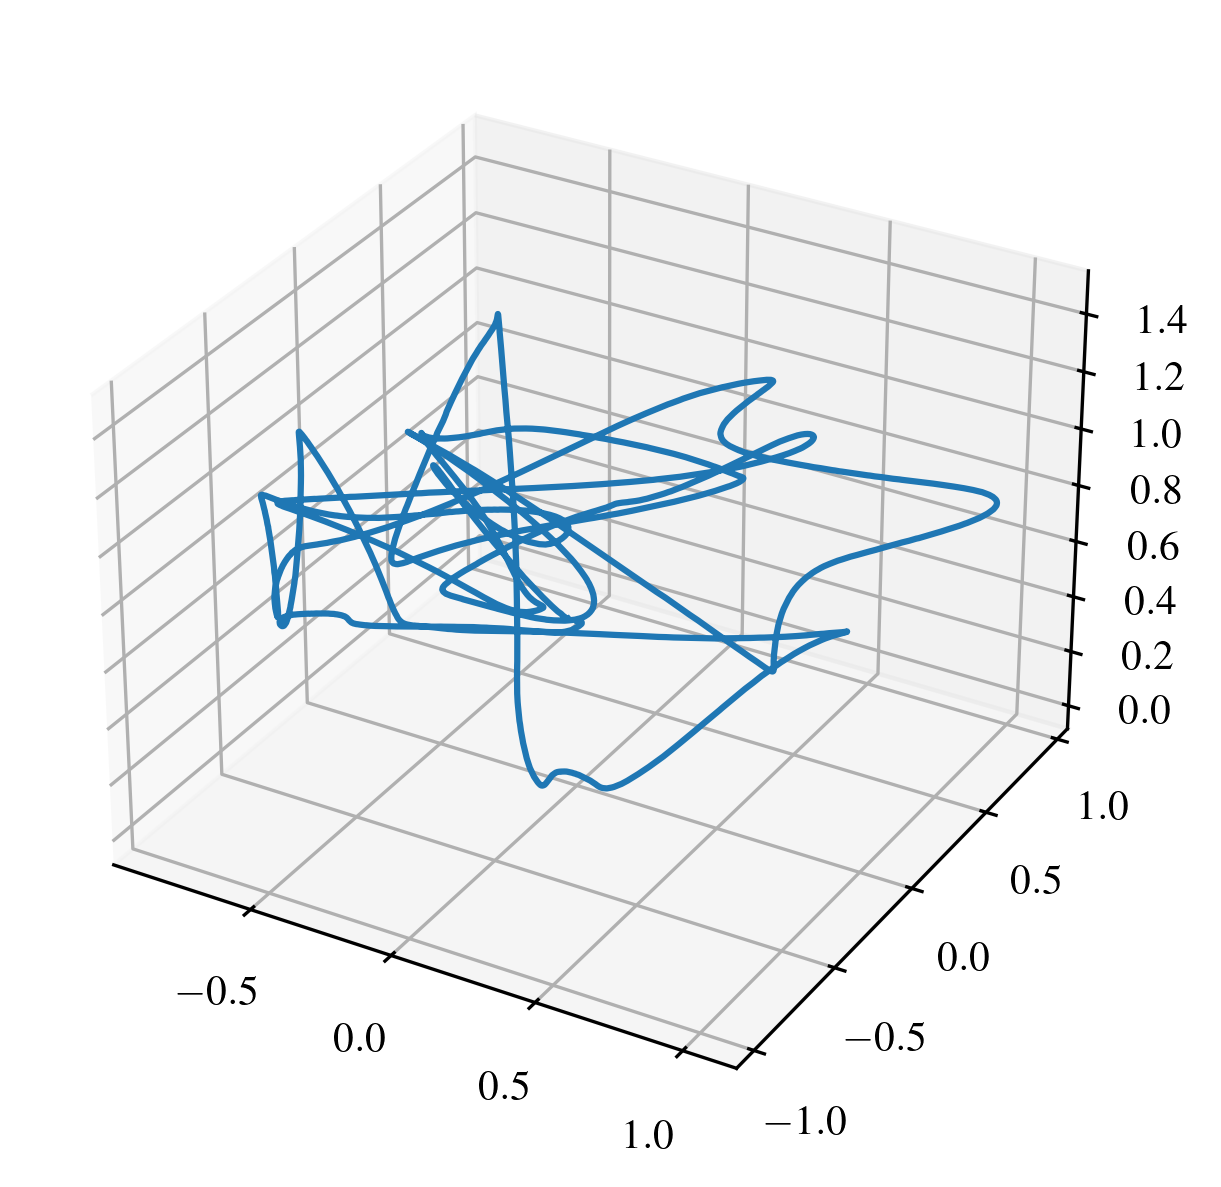

In [19]:
for dp in ["helix_fast/li00", "figure_8_tests/li00", "circle_test/li00", "final_data/li00"]:
    fig = plt.figure(dpi=300)
    ax = plt.axes(projection='3d')

    data = cfusdlog.decode(dp)['fixedFrequency']

    x = [i for i in data["stateEstimate.x"]]
    y = [i for i in data["stateEstimate.y"]]
    z = [i for i in data["stateEstimate.z"]]
    origin = np.array([x, y, z]).T

    ax.plot3D(x, y, z)

    plt.axis('equal')
    plt.show()